The Ulitmate Fighter Championship (UFC) is an America Mixed Martial Arts promotion at the frontier of the sport. Since 1993, The UFC has hosted over 500 events, each of which has up to 20 fights. The fights are made and announced by matchemakers and the fighters who are all members of the UFC roster. In the roster there are 8 weight classes for men and 4 weight classes for women, each weight class consisting of approximately 50 fighters. Fighters signed to the UFC typically have made a name for themselves in other combat sports or are elite prospects from smaller or regional MMA promotions, so the UFC has been able to boast the best of the best during its existance.

On a given fight night, the fights are made of about 5 fights on the undercard and 5 fights on the main card. The undercard typically consists of new signees and low ranked fights while the main card will include 3-4 mid-ranked fighters with 1-2 high profile bouts, also known as the main event. There is no restriction on which weight class must have a fight on card. Each of the fights consist of three 5 minute rounds (execpt the main event, which has five rounds) where the fight will continue until time runs out and the fight is determined by a decsion by judges or the ref determines that one fighter has ceased to inteligently defend themselves. The ref's decsion can come from several different situations incuding a submission, knockout, or technical knockout.



In [65]:
# Necessary libraries and imports to complete this tutorial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
import seaborn as sns
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
import datetime 
import warnings
warnings.filterwarnings('ignore')

READING DATA

In [3]:
#data = pd.read_csv("preprocessed_data.csv")
data = pd.read_csv("data.csv")

#data.head()



,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0.0,...,2.0,0.0,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0.0,...,0.0,2.0,0.0,5.0,Southpaw,165.10,167.64,125.0,32.0,31.0
2,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Red,False,Lightweight,3,0.0,...,3.0,6.0,1.0,14.0,Orthodox,180.34,193.04,155.0,36.0,35.0
3,Jimmie Rivera,Petr Yan,Kevin MacDonald,2019-06-08,"Chicago, Illinois, USA",Blue,False,Bantamweight,3,0.0,...,1.0,0.0,0.0,6.0,Orthodox,162.56,172.72,135.0,26.0,29.0
4,Tai Tuivasa,Blagoy Ivanov,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Blue,False,Heavyweight,3,0.0,...,2.0,0.0,0.0,3.0,Southpaw,187.96,190.50,264.0,32.0,26.0


Fighters are represented by red and blue, by the color of their corners. In general, the red cornor is assigned to the side more notable and thus more favored to win. This is also observed in how the blue cornor, by custom, always walks out first. In title bouts, the current champion is always red and walks out second. Each row is a compilation of both fighter stats up to the the current fight. The columns contain complied average stats of all the fights previously. 
*** ADD INFO ON COLUMN LABEL DESCRIPTION ***
The data consists of logistics about the fight and data specific to each fighter. The data pertaining to the red fighter is prefixed with 'R_' and for the blue fighter 'B_'. The 'opp_' tag indicates data done by the opponent on the fighter. The target variable is 'Winner' which is the only column that tells you the outcome of the fight.

Since there are well over 100 columns of data, we will select a sample of the columns to explore. 

TIDYING AND SELECTING DATA

# PICK COLUMNS, MAKE SMALLER DATA FRAMES FOR EDA

Immediatly, we can see that depending on the cricumstances of the fight, red fighters have been favored over the years. Though this isn't a completely reliable metric in predicting fights, there is a variance in the favoring when adjusting the fight logistics. There are three types of fights: Title fights (always 5 rounds), 5 round non-title fights, and 3 round fights (always non-title). There are 5144 fights in the data set and the the five round fights make up 502 of them. The variance in red favoring is distinct in each of these three fight categories:

In [4]:
# Count fights by nunmber of rounds and title fight indicator.
title_df = data.loc[data['title_bout'] == True]
five_df = data.loc[(data['no_of_rounds'] == 5) & (data['title_bout'] == False)]
three_df = data.loc[data['no_of_rounds'] == 3]

print('The number of title fights: ', title_df.shape[0])
print('The number of five round non-title fights: ', five_df.shape[0])
print('The number three round fights: ', three_df.shape[0])

print('Probability red fighter wins in title fight: ', title_df[title_df['Winner'] == 'Red'].shape[0]/title_df.shape[0])
print('Probability red fighter wins in 5 round non-title fight: ', five_df[five_df['Winner'] == 'Red'].shape[0]/five_df.shape[0])
print('Probability red fighter wins in a 3 round fight: ', three_df[three_df['Winner'] == 'Red'].shape[0]/three_df.shape[0])

The number of title fights:  335
The number of five round non-title fights:  177
The number three round fights:  4523
Probability red fighter wins in title fight:  0.8029850746268656
Probability red fighter wins in 5 round non-title fight:  0.5536723163841808
Probability red fighter wins in a 3 round fight:  0.6615078487729383


Since the data is averaged based on each fight, it is important to include the statstics of the opponent ('opp') historical data since not all fights are the same length. The data includes many columns specifying types of attacks landed and attempted and is seperated in to grappling and striking sections. The striking data has averages Body, Clinch, Distance, Ground, Head, Leg, Knockdowns, and Significant Strikes and grappling data for Pass, Reverasals, Submissions, and Takedowns. A visual representation of some of these can be found here: https://www.theguardian.com/sport/ng-interactive/2016/jul/09/mixed-martial-arts-fighting-techniques-guide-ufc#:~:text=Boxing%2C%20Kickboxing%20and%20Muay%20Thai,and%20legs%20to%20throw%20strikes.

To arrange the data, we will seperate the specific types of attacks from the totals. For matters of a different perspective, we will also create a dataframe that includes non-fight related metrics such as age, height, reach, stance, etc. Lastly, we will create two more dataframes storing the specifcs of the striking and grappling data.

In [5]:
metrics_df = data[['R_fighter','B_fighter','Winner','B_Stance','B_Height_cms','B_Reach_cms','B_age','B_wins','B_losses','R_Stance','R_Height_cms','R_Reach_cms','R_age','R_wins','R_losses']]
#metrics_df.head()   

In [6]:
totals_df = data[['R_fighter','B_fighter','weight_class','Winner','R_avg_TOTAL_STR_att','R_avg_TOTAL_STR_landed','R_avg_opp_TOTAL_STR_att','R_avg_opp_TOTAL_STR_landed','B_avg_TOTAL_STR_att','B_avg_TOTAL_STR_landed','B_avg_opp_TOTAL_STR_att','B_avg_opp_TOTAL_STR_landed']]
#totals_df.head()

In [7]:
grappling_df = data[['R_fighter','B_fighter','weight_class','Winner','R_avg_PASS','R_avg_REV','R_avg_SUB_ATT','R_avg_TD_att','R_avg_TD_landed','R_avg_TD_pct','B_avg_PASS','B_avg_REV','B_avg_SUB_ATT','B_avg_TD_att','B_avg_TD_landed','B_avg_TD_pct']]
opp_grappling_df = data[['R_fighter','B_fighter','weight_class','Winner','R_avg_opp_PASS','R_avg_opp_REV','R_avg_opp_SUB_ATT','R_avg_opp_TD_att','R_avg_opp_TD_landed','R_avg_opp_TD_pct','B_avg_opp_PASS','B_avg_opp_REV','B_avg_opp_SUB_ATT','B_avg_opp_TD_att','B_avg_opp_TD_landed','B_avg_opp_TD_pct']]

#grappling_df.head()

In [8]:
striking_df = data[['R_fighter','B_fighter','weight_class','Winner','R_avg_BODY_att','R_avg_BODY_landed','R_avg_CLINCH_att','R_avg_CLINCH_landed','R_avg_DISTANCE_att','R_avg_DISTANCE_landed','R_avg_GROUND_att','R_avg_GROUND_landed','R_avg_HEAD_att','R_avg_HEAD_landed','R_avg_LEG_att','R_avg_LEG_landed','R_avg_KD','B_avg_BODY_att','B_avg_BODY_landed','B_avg_CLINCH_att','B_avg_CLINCH_landed','B_avg_DISTANCE_att','B_avg_DISTANCE_landed','B_avg_GROUND_att','B_avg_GROUND_landed','B_avg_HEAD_att','B_avg_HEAD_landed','B_avg_LEG_att','B_avg_LEG_landed','B_avg_KD']]
opp_striking_df = data[['R_fighter','B_fighter','weight_class','Winner','R_avg_opp_BODY_att','R_avg_opp_BODY_landed','R_avg_opp_CLINCH_att','R_avg_opp_CLINCH_landed','R_avg_opp_DISTANCE_att','R_avg_opp_DISTANCE_landed','R_avg_opp_GROUND_att','R_avg_opp_GROUND_landed','R_avg_opp_HEAD_att','R_avg_opp_HEAD_landed','R_avg_opp_LEG_att','R_avg_opp_LEG_landed','R_avg_opp_KD','B_avg_opp_BODY_att','B_avg_opp_BODY_landed','B_avg_opp_CLINCH_att','B_avg_opp_CLINCH_landed','B_avg_opp_DISTANCE_att','B_avg_opp_DISTANCE_landed','B_avg_opp_GROUND_att','B_avg_opp_GROUND_landed','B_avg_opp_HEAD_att','B_avg_opp_HEAD_landed','B_avg_opp_LEG_att','B_avg_opp_LEG_landed','B_avg_opp_KD']]

#striking_df.head()

EDA
Which fighters had some of the most significant averages? Heading into fights, some fighters will have standout averages that highlight what has worked for them in the past.

First we can observe some of the highest averages i

In [14]:
# observe win distributions in reach and age differences

age_diff = pd.Series(name='age_diff', dtype='float64')
reach_diff = pd.Series(name='age_diff', dtype='float64')
for row_index,row in metrics_df.iterrows():
    a = row['R_age'] - row['B_age']
    r = row['R_Reach_cms'] - row['B_Reach_cms']
    
    if (row['Winner'] == 'Blue'):
        a = row['B_age'] - row['R_age']
        r = row['B_Reach_cms'] - row['R_Reach_cms']
    
    age_diff = age_diff.append(pd.Series(a))
    reach_diff = reach_diff.append(pd.Series(r))

age_diff_list = age_diff.tolist()
data['age_diff'] = age_diff_list

reach_diff_list = reach_diff.tolist()
data['reach_diff'] = reach_diff_list

out = pd.cut(age_diff, bins=list(range(-23,17,2)), include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="k", figsize=(10,10))
plt.xticks(rotation='45')
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.show()

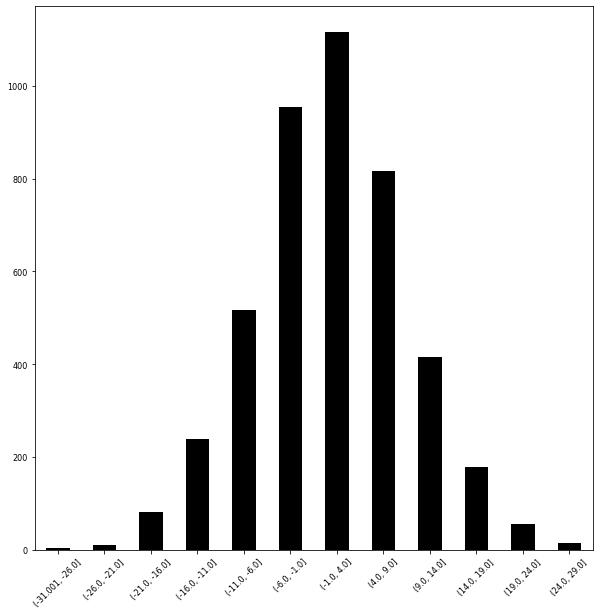

In [38]:
out = pd.cut(reach_diff, bins=list(range(-31,34,5)), include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="k", figsize=(10,10))
plt.xticks(rotation='45')
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.show()

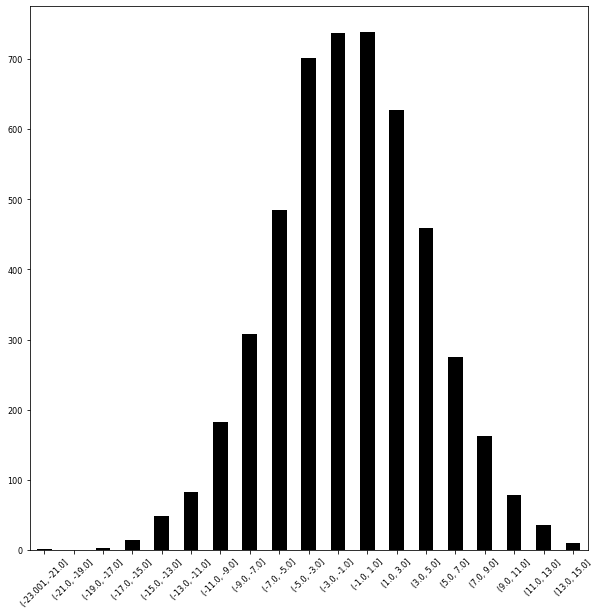

In [68]:
out = pd.cut(age_diff, bins=list(range(-23,17,2)), include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="k", figsize=(10,10))
plt.xticks(rotation='45')
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.show()

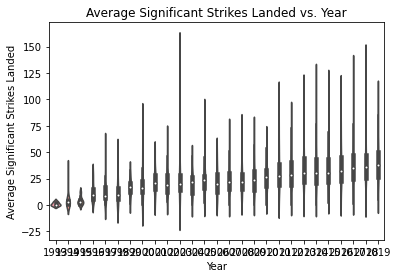

In [32]:
# Explore how striking and striking defence has changed over time.

data['date'] = pd.to_datetime(data['date'])
year_list = [i.year for i in data['date']]

fig = sns.violinplot(x=year_list, y=np.array(data['R_avg_SIG_STR_landed']))
fig.set(xlabel="Year", ylabel="Average Significant Strikes Landed", title="Average Significant Strikes Landed vs. Year");


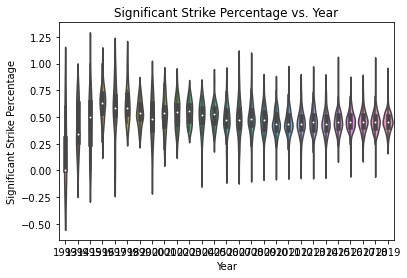

In [34]:
fig = sns.violinplot(x=year_list, y=np.array(data['R_avg_SIG_STR_pct']))
fig.set(xlabel="Year", ylabel="Significant Strike Percentage", title="Significant Strike Percentage vs. Year");

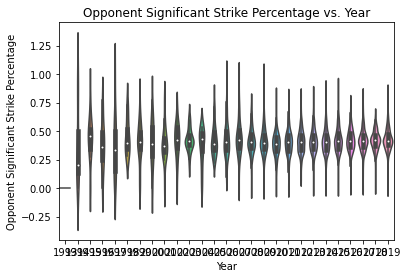

In [35]:
fig = sns.violinplot(x=year_list, y=np.array(data['R_avg_opp_SIG_STR_pct']))
fig.set(xlabel="Year", ylabel="Opponent Significant Strike Percentage", title="Opponent Significant Strike Percentage vs. Year");

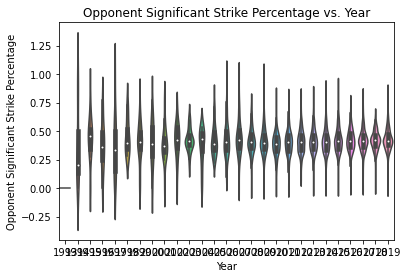

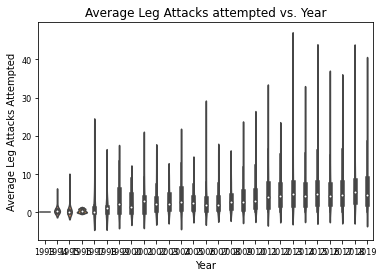

In [40]:
fig = sns.violinplot(x=year_list, y=np.array(data['R_avg_LEG_landed']))
fig.set(xlabel="Year", ylabel="Average Leg Attacks Attempted", title="Average Leg Attacks attempted vs. Year");

The debate about who the "goat" of MMA is, is one that is everalasting and constantly evolving. With the advent of new fighters, new fighting styles, and new champions every year, it is interesting to observe which fighters stood out in each of the 

In [66]:
data_filtered = data[(data['R_wins'] + data['R_losses'] >= 5) & (data['date'] > datetime.datetime(2010, 1, 1))] 

In [67]:
print(data_filtered.sort_values(by=['R_avg_SUB_ATT'], ascending=False)[['R_fighter','R_avg_SUB_ATT']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_HEAD_landed'], ascending=False)[['R_fighter','R_avg_HEAD_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_LEG_landed'], ascending=False)[['R_fighter','R_avg_LEG_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_TOTAL_STR_landed'], ascending=False)[['R_fighter','R_avg_TOTAL_STR_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_total_title_bouts'], ascending=False)[['R_fighter','R_total_title_bouts']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_KD'], ascending=False)[['R_fighter','R_avg_KD']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_SIG_STR_landed'], ascending=False)[['R_fighter','R_avg_SIG_STR_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_PASS'], ascending=False)[['R_fighter','R_avg_PASS']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_TD_pct'], ascending=False)[['R_fighter','R_avg_TD_pct']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))


# Lets look at who some of the best fighters are defensively.
print(data_filtered.sort_values(by=['R_avg_opp_HEAD_landed'], ascending=True)[['R_fighter','R_avg_opp_HEAD_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_opp_TD_landed'], ascending=True)[['R_fighter','R_avg_opp_TD_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_opp_DISTANCE_landed'], ascending=True)[['R_fighter','R_avg_opp_DISTANCE_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))


                R_fighter  R_avg_SUB_ATT
2717        TJ Waldburger       3.000000
3893          Cole Miller       2.666667
1283         Louis Smolka       2.500000
3734           Joe Lauzon       2.428571
3748        Stefan Struve       2.400000
3065         Alex Caceres       2.200000
3004           Jim Miller       2.076923
1310          Chas Skelly       2.000000
719          Jason Knight       2.000000
3764  George Sotiropoulos       2.000000
                  R_fighter  R_avg_HEAD_landed
795      Joanna Jedrzejczyk          68.500000
86             Max Holloway          62.842105
2546               Nam Phan          62.571429
591             Evan Dunham          56.222222
1178     Valerie Letourneau          55.000000
1556         Corey Anderson          52.400000
1149          Dominick Cruz          52.200000
617         Jessica Andrade          51.916667
590   Karolina Kowalkiewicz          51.333333
347     Khabib Nurmagomedov          51.200000
               R_fighter  R_avg_